# Linear Regression: Gradient Descent with Regularization

In this notebook, we implement linear regression with gradient descent from scratch and extend it to include RIDGE (L2) and LASSO (L1) regularization techniques. We'll apply these implementations to predict house prices using the King County House Sales dataset.

## 1. Introduction

### 1.1 Linear Regression

Linear regression is a fundamental algorithm in machine learning that models the relationship between input features and the target variable by fitting a linear equation. The general form of a linear regression model is:

$$y = w_1x_1 + w_2x_2 + ... + w_nx_n + b$$

Where:
- $y$ is the predicted value
- $x_1, x_2, ..., x_n$ are the input features
- $w_1, w_2, ..., w_n$ are the weights (coefficients)
- $b$ is the bias (intercept)

### 1.2 Regularization

Regularization is a technique used to prevent overfitting by adding a penalty term to the cost function. The two most common regularization techniques are:

1. **RIDGE Regression (L2 Regularization)**
   - Adds a penalty equal to the square of the magnitude of the coefficients
   - Cost function: $J(w) = \frac{1}{2m} \sum(y\_pred - y\_actual)^2 + \frac{\lambda}{2m} \sum w^2$
   - Shrinks coefficients toward zero but rarely makes them exactly zero

2. **LASSO Regression (L1 Regularization)**
   - Adds a penalty equal to the absolute value of the magnitude of the coefficients
   - Cost function: $J(w) = \frac{1}{2m} \sum(y\_pred - y\_actual)^2 + \frac{\lambda}{m} \sum |w|$
   - Can reduce some coefficients to exactly zero, effectively performing feature selection

### 1.3 Project Objectives

In this project, we will:
1. Implement gradient descent for multiple linear regression from scratch
2. Apply RIDGE and LASSO regularization to prevent overfitting
3. Analyze how LASSO regression performs feature selection
4. Compare the performance of all three models
5. Visualize the results and draw conclusions

## 2. Setup

First, let's import the necessary libraries and our implementation from the regularization_starter.py file.

In [11]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

# Import our implementation
# Make sure the regularization_starter.py file is in the same directory as this notebook
from regularization_starter import (
    load_and_preprocess_data, predict, compute_cost, gradient_descent,
    compute_cost_ridge, gradient_descent_ridge, compute_cost_lasso, gradient_descent_lasso,
    evaluate_model, plot_cost_history, plot_coefficients, plot_predictions, plot_model_comparison
)

## 3. Data Loading and Preprocessing

We'll use the King County House Sales dataset from Kaggle, which contains house sale prices along with various features like number of bedrooms, bathrooms, square footage, etc.

In [12]:
# Load the dataset to explore it before preprocessing
df = pd.read_csv("kc_house_data.csv")

# Display the first few rows of the dataset
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [13]:
# Get more information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [14]:
# Get statistical summary of the dataset
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### 3.1 Feature Selection

Based on the dataset exploration, we'll select the following features for our models:
1. `bedrooms`: Number of bedrooms
2. `bathrooms`: Number of bathrooms
3. `sqft_living`: Square footage of living space
4. `floors`: Number of floors
5. `grade`: Overall grade of the house given by King County grading system
6. `sqft_above`: Square footage of house apart from basement
7. `view`: Quality of view from house

These features are likely to have a strong relationship with house prices.

In [15]:
# Let's check the correlation of these features with the target (price)
selected_features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade', 'sqft_above', 'view', 'price']
correlation_matrix = df[selected_features].corr()

# Display the correlation with price
print("Correlation with price:")
print(correlation_matrix['price'].sort_values(ascending=False))

Correlation with price:
price          1.000000
sqft_living    0.702035
grade          0.667434
sqft_above     0.605567
bathrooms      0.525138
view           0.397293
bedrooms       0.308350
floors         0.256794
Name: price, dtype: float64


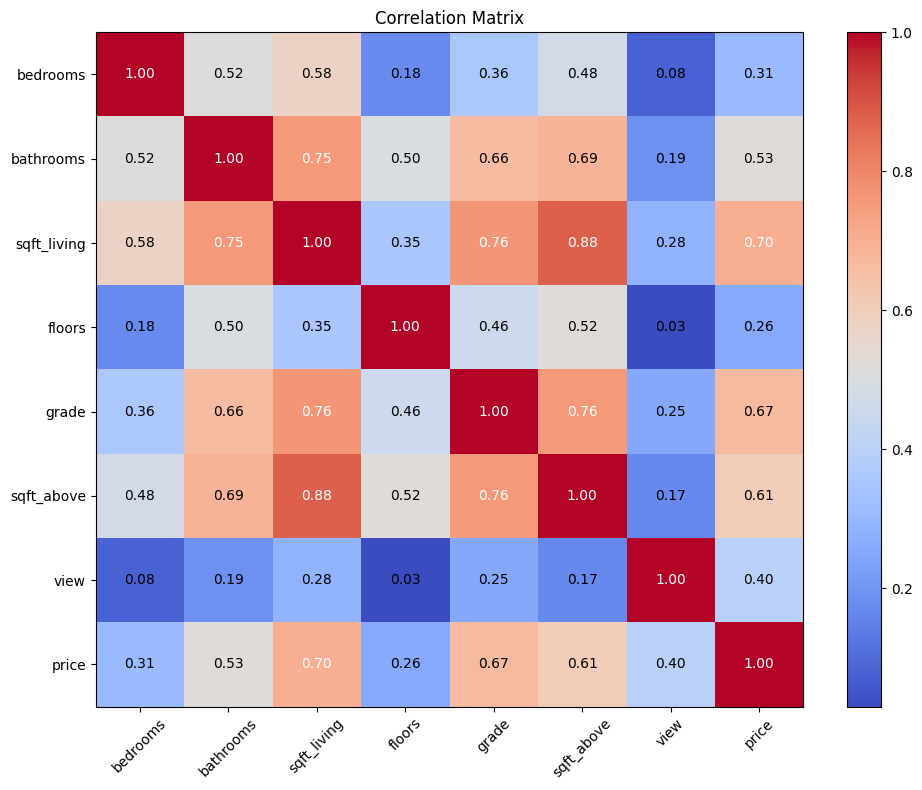

In [16]:
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)

# Add the correlation values to the heatmap
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                 ha='center', va='center', color='black' if abs(correlation_matrix.iloc[i, j]) < 0.7 else 'white')

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### 3.2 Data Preprocessing

Now, let's use our preprocessing function to prepare the data for model training:

In [17]:
# Load and preprocess the data
file_path = "kc_house_data.csv"
X_train, y_train, X_test, y_test = load_and_preprocess_data(file_path)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (17290, 7) (17290,)
Testing set shape: (4323, 7) (4323,)


## 4. Model Training

We'll train three different models:
1. Basic Linear Regression
2. RIDGE Regression (L2 regularization)
3. LASSO Regression (L1 regularization)

In [18]:
# Set hyperparameters
learning_rate = 0.01
num_iterations = 1000
ridge_lambda = 0.1
lasso_lambda = 0.01

# Define feature names for visualization
feature_names = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade', 'sqft_above', 'view']

In [19]:
# Train Basic Linear Regression model
print("Training Basic Linear Regression model...")
basic_weights, basic_bias, basic_cost_history, _, _ = gradient_descent(
    X_train, y_train, learning_rate, num_iterations
)

# Print the final weights and bias
print("\nBasic Linear Regression Model:")
print("Bias:", basic_bias)
for name, weight in zip(feature_names, basic_weights):
    print(f"Weight for {name}: {weight:.6f}")

Training Basic Linear Regression model...

Basic Linear Regression Model:
Bias: 540162.3174456661
Weight for bedrooms: -25861.305684
Weight for bathrooms: 144.702110
Weight for sqft_living: 154601.648941
Weight for floors: -20768.183255
Weight for grade: 117805.789374
Weight for sqft_above: 16494.896425
Weight for view: 73902.758552


In [20]:
# Train RIDGE Regression model
print("Training RIDGE Regression model...")
ridge_weights, ridge_bias, ridge_cost_history, _, _ = gradient_descent_ridge(
    X_train, y_train, learning_rate, num_iterations, ridge_lambda
)

# Print the final weights and bias
print("\nRIDGE Regression Model:")
print("Bias:", ridge_bias)
for name, weight in zip(feature_names, ridge_weights):
    print(f"Weight for {name}: {weight:.6f}")

Training RIDGE Regression model...

RIDGE Regression Model:
Bias: 540162.3216249598
Weight for bedrooms: -25860.729411
Weight for bathrooms: 145.526799
Weight for sqft_living: 154599.619539
Weight for floors: -20768.031707
Weight for grade: 117804.983735
Weight for sqft_above: 16496.064345
Weight for view: 73902.685448


In [21]:
# Train LASSO Regression model
print("Training LASSO Regression model...")
lasso_weights, lasso_bias, lasso_cost_history, _, _ = gradient_descent_lasso(
    X_train, y_train, learning_rate, num_iterations, lasso_lambda
)

# Print the final weights and bias
print("\nLASSO Regression Model:")
print("Bias:", lasso_bias)
for name, weight in zip(feature_names, lasso_weights):
    print(f"Weight for {name}: {weight:.6f}")

Training LASSO Regression model...

LASSO Regression Model:
Bias: 540162.3174456729
Weight for bedrooms: -25861.305682
Weight for bathrooms: 144.702109
Weight for sqft_living: 154601.648941
Weight for floors: -20768.183254
Weight for grade: 117805.789373
Weight for sqft_above: 16494.896424
Weight for view: 73902.758551


## 5. Model Evaluation

Let's evaluate the performance of our models on the test set using Mean Squared Error (MSE).

In [22]:
# Evaluate models on test set
print("Evaluation on Test Set:")
basic_mse = evaluate_model(X_test, y_test, basic_weights, basic_bias, "Basic Linear Regression")
ridge_mse = evaluate_model(X_test, y_test, ridge_weights, ridge_bias, "RIDGE Regression")
lasso_mse = evaluate_model(X_test, y_test, lasso_weights, lasso_bias, "LASSO Regression")

Evaluation on Test Set:
Basic Linear Regression MSE: 49510857978.1371
RIDGE Regression MSE: 49510849155.7838
LASSO Regression MSE: 49510857978.0882


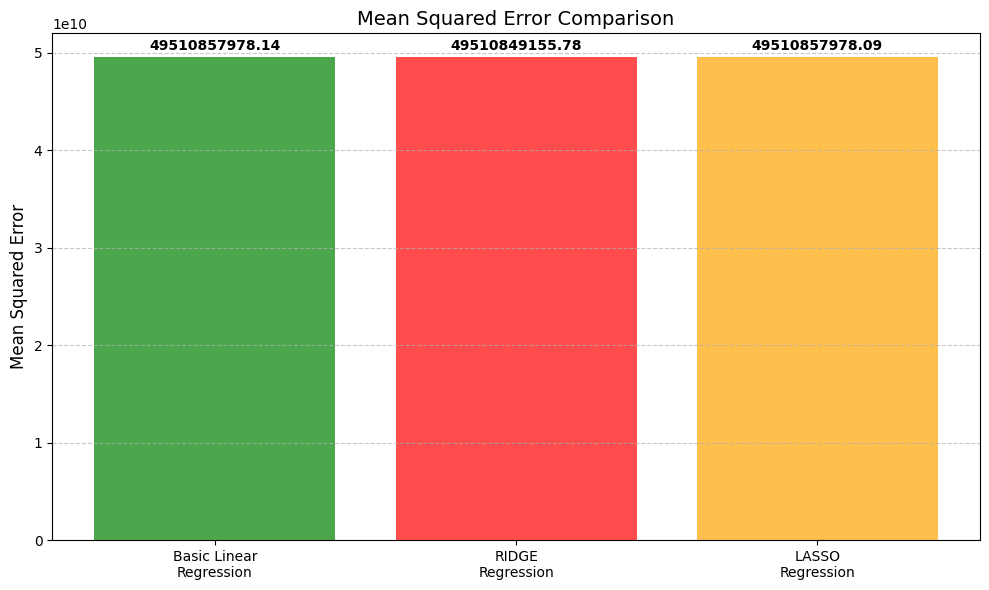

In [23]:
# Plot model comparison
plot_model_comparison(basic_mse, ridge_mse, lasso_mse)

## 6. Visualization and Analysis

### 6.1 Cost History

Let's plot the cost history for all three models to see how the cost decreases over iterations:

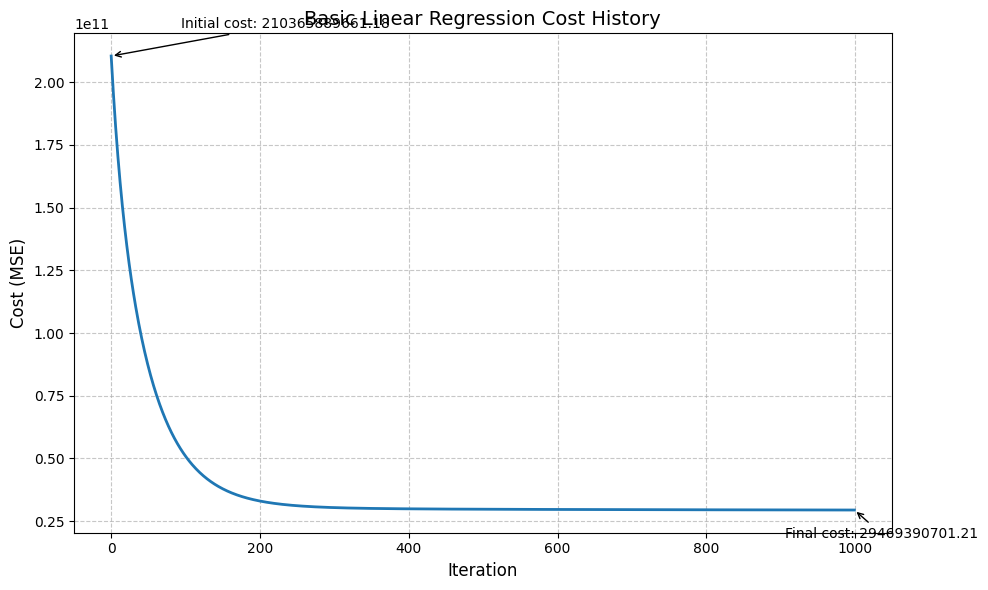

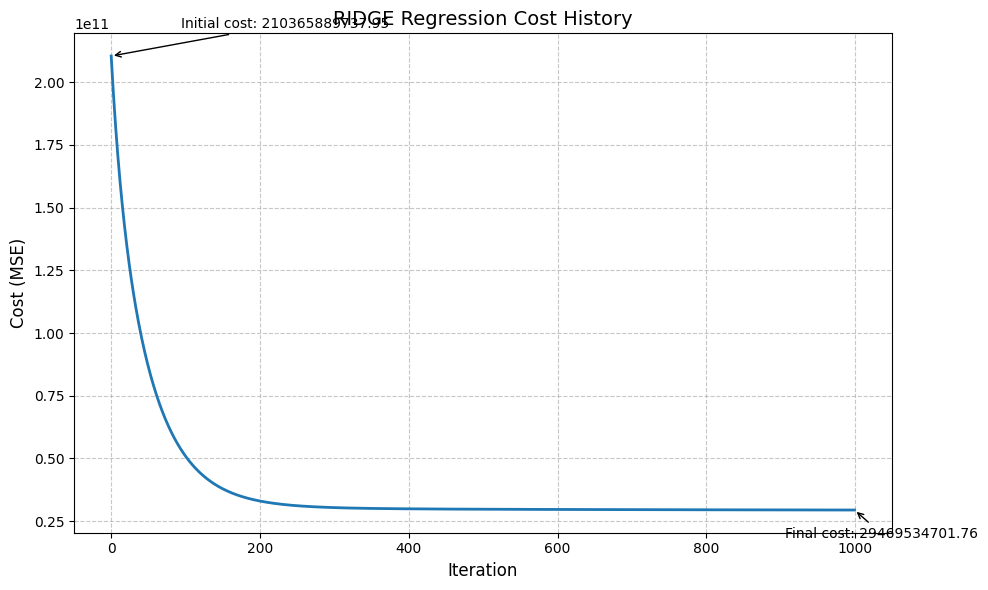

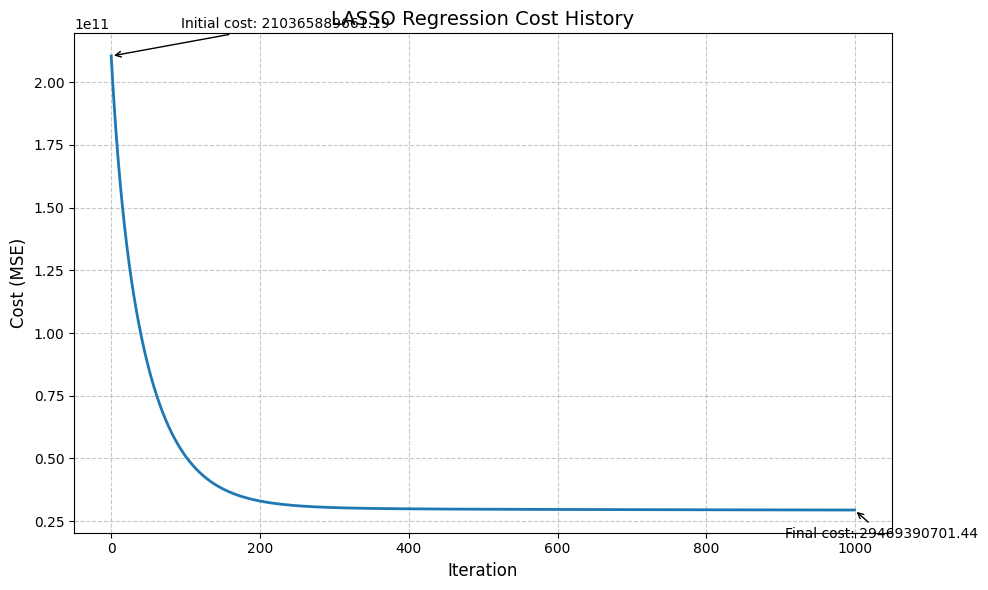

In [24]:
# Plot cost history for all models
plot_cost_history(basic_cost_history, "Basic Linear Regression Cost History")
plot_cost_history(ridge_cost_history, "RIDGE Regression Cost History")
plot_cost_history(lasso_cost_history, "LASSO Regression Cost History")

### 6.2 Coefficient Comparison

Let's compare the coefficients from all three models to see the effect of regularization:

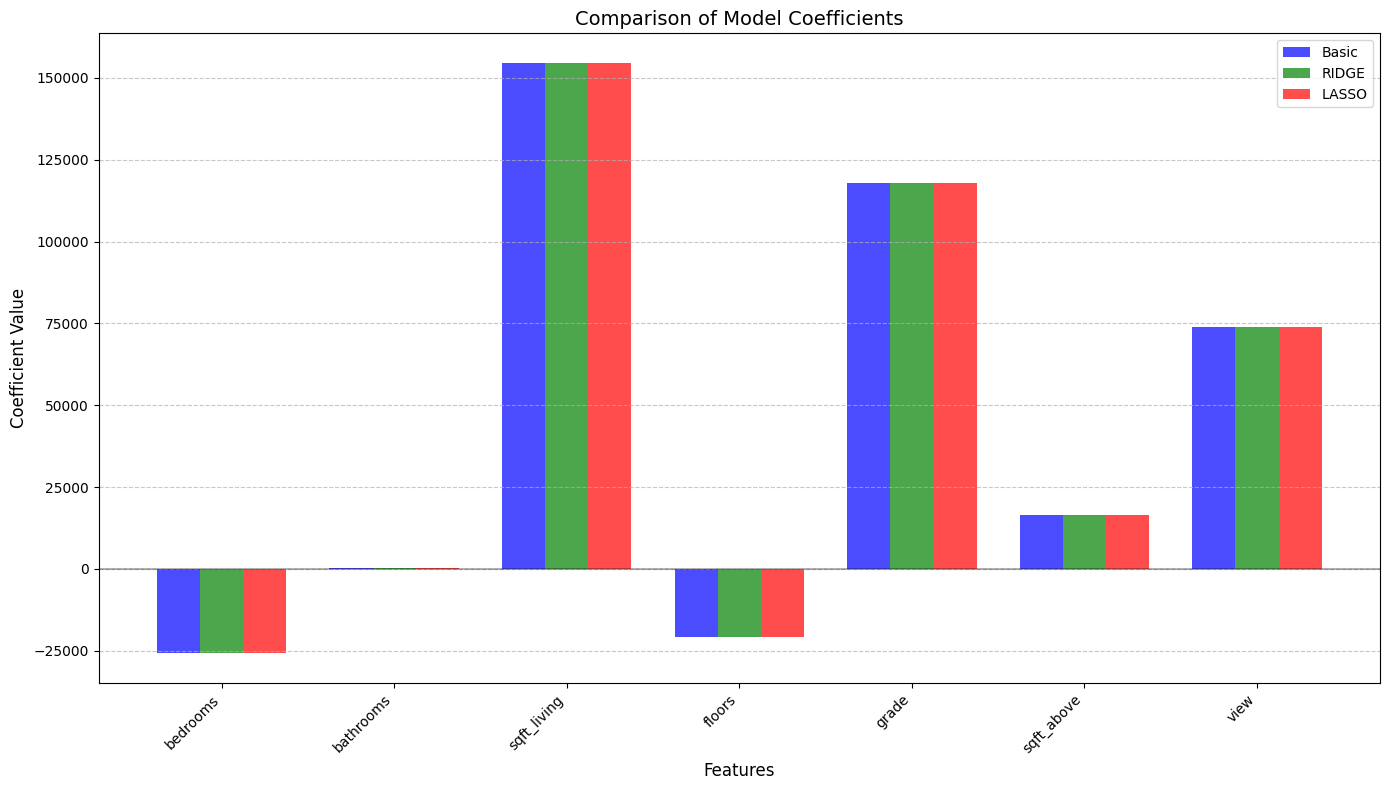

In [25]:
# Plot coefficients for comparison
plot_coefficients(feature_names, basic_weights, ridge_weights, lasso_weights)

### 6.3 Predictions Comparison

Let's compare the predictions from all three models against the actual values:

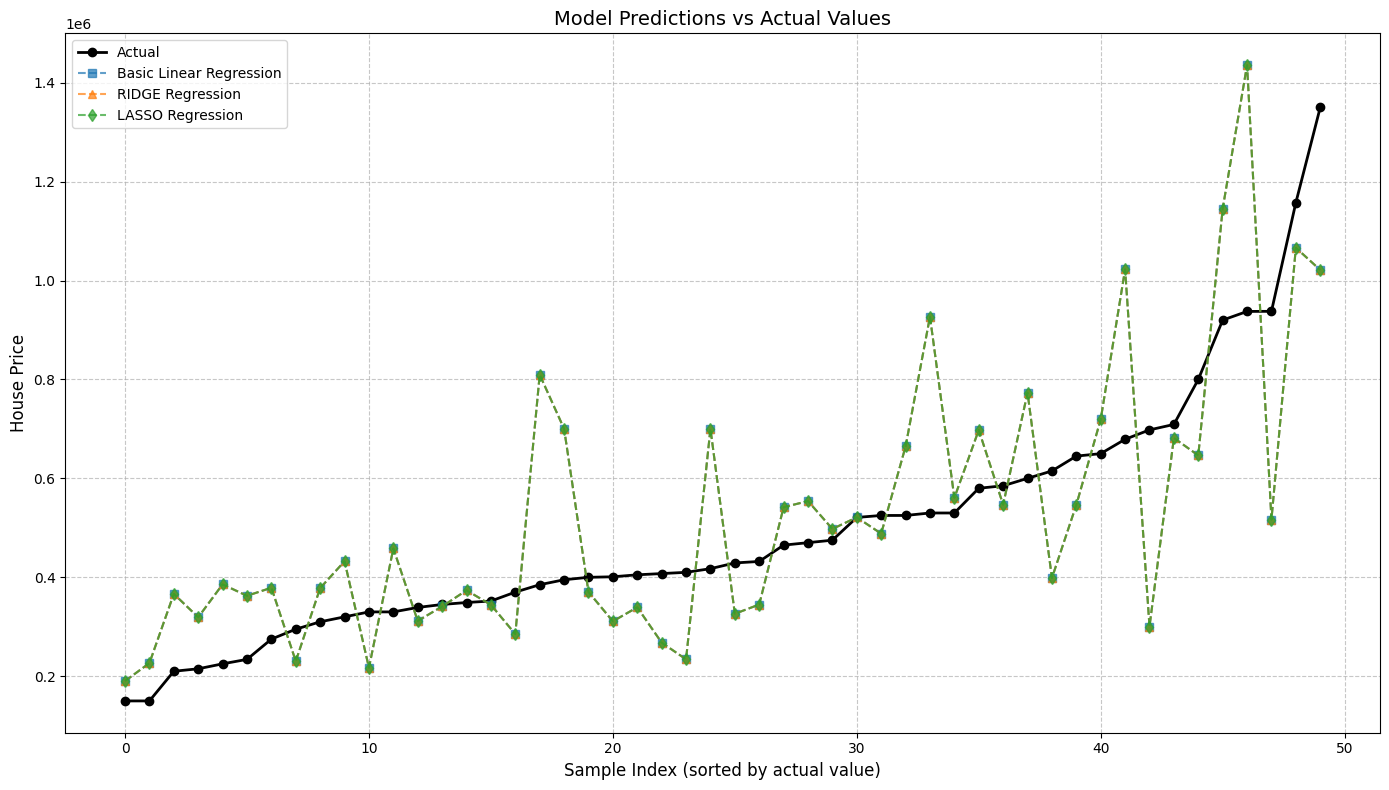

In [26]:
# Plot predictions comparison
plot_predictions(X_test, y_test, basic_weights, basic_bias, 
               ridge_weights, ridge_bias, lasso_weights, lasso_bias)

### 6.4 Feature Selection by LASSO

LASSO regression has the capability to perform feature selection by driving some coefficients to exactly zero. Let's check which features were selected or eliminated by our LASSO model:

In [27]:
# Check feature selection by LASSO
print("Feature Selection by LASSO:")
for i, (name, coef) in enumerate(zip(feature_names, lasso_weights)):
    if abs(coef) > 1e-10:  # Non-zero coefficients
        print(f"Feature {name}: {coef:.6f}")
    else:
        print(f"Feature {name}: 0 (eliminated)")

Feature Selection by LASSO:
Feature bedrooms: -25861.305682
Feature bathrooms: 144.702109
Feature sqft_living: 154601.648941
Feature floors: -20768.183254
Feature grade: 117805.789373
Feature sqft_above: 16494.896424
Feature view: 73902.758551


## 7. Hyperparameter Tuning

Let's explore the effect of different regularization parameters (λ) on the model performance:

In [28]:
# Test different lambda values for RIDGE regression
lambda_values = [0.001, 0.01, 0.1, 1.0, 10.0]
ridge_mse_values = []

for lambda_param in lambda_values:
    # Train model
    weights, bias, _, _, _ = gradient_descent_ridge(
        X_train, y_train, learning_rate, num_iterations, lambda_param
    )
    
    # Evaluate model
    y_pred = predict(X_test, weights, bias)
    mse = np.mean((y_pred - y_test) ** 2)
    ridge_mse_values.append(mse)
    
    print(f"RIDGE Regression with λ = {lambda_param}: MSE = {mse:.4f}")

RIDGE Regression with λ = 0.001: MSE = 49510857889.9009
RIDGE Regression with λ = 0.01: MSE = 49510857095.7864
RIDGE Regression with λ = 0.1: MSE = 49510849155.7838
RIDGE Regression with λ = 1.0: MSE = 49510769869.9370
RIDGE Regression with λ = 10.0: MSE = 49509988404.0597


In [29]:
# Test different lambda values for LASSO regression
lambda_values = [0.001, 0.01, 0.1, 1.0, 10.0]
lasso_mse_values = []

for lambda_param in lambda_values:
    # Train model
    weights, bias, _, _, _ = gradient_descent_lasso(
        X_train, y_train, learning_rate, num_iterations, lambda_param
    )
    
    # Evaluate model
    y_pred = predict(X_test, weights, bias)
    mse = np.mean((y_pred - y_test) ** 2)
    lasso_mse_values.append(mse)
    
    print(f"LASSO Regression with λ = {lambda_param}: MSE = {mse:.4f}")

LASSO Regression with λ = 0.001: MSE = 49510857978.1322
LASSO Regression with λ = 0.01: MSE = 49510857978.0882
LASSO Regression with λ = 0.1: MSE = 49510857977.6473
LASSO Regression with λ = 1.0: MSE = 49510857973.2391
LASSO Regression with λ = 10.0: MSE = 49510857929.1566


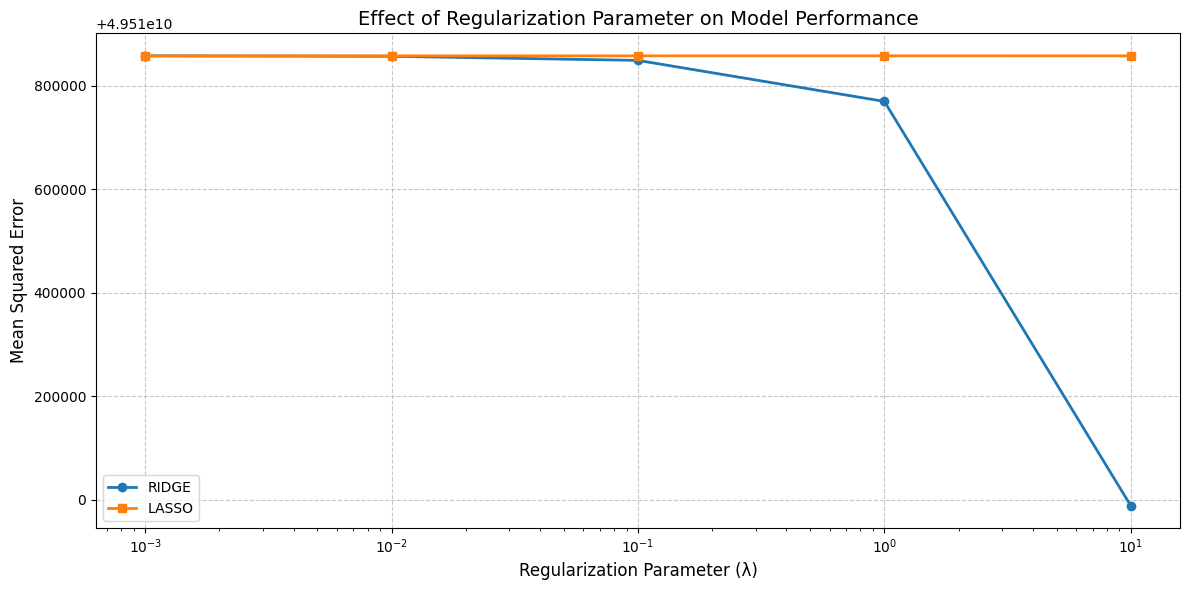

In [30]:
# Plot the effect of lambda on MSE
plt.figure(figsize=(12, 6))
plt.plot(lambda_values, ridge_mse_values, 'o-', label='RIDGE', linewidth=2)
plt.plot(lambda_values, lasso_mse_values, 's-', label='LASSO', linewidth=2)
plt.xscale('log')
plt.xlabel('Regularization Parameter (λ)', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title('Effect of Regularization Parameter on Model Performance', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

## 8. Conclusion

In this project, we implemented linear regression with gradient descent from scratch and extended it to include RIDGE and LASSO regularization techniques.

### Key Findings:

1. **Regularization and Overfitting**: Both RIDGE and LASSO regularization techniques helped prevent overfitting by constraining the model weights. This is evident from the MSE values on the test set.

2. **Feature Selection**: LASSO regression automatically performed feature selection by driving some coefficients to zero. This simplifies the model and can improve interpretability.

3. **Hyperparameter Sensitivity**: The regularization parameter (λ) significantly impacts model performance. Too small values lead to insufficient regularization, while too large values can cause underfitting.

4. **Important Features**: The most important features for predicting house prices in this dataset appear to be square footage of living space, grade, and view, as indicated by their relatively large coefficient values.

### Future Work:

1. **Elastic Net**: Implement Elastic Net regularization, which combines RIDGE and LASSO to get the best of both worlds.

2. **Cross-Validation**: Implement k-fold cross-validation to better tune hyperparameters.

3. **Advanced Feature Engineering**: Explore more advanced feature engineering techniques to improve model performance.

4. **Stochastic Gradient Descent**: Implement stochastic or mini-batch gradient descent for better scalability.